In [1]:
import os,glob
import pandas as pd
import pygmt
import pickle
import warnings  
warnings.filterwarnings("ignore")

In [2]:
pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '8',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')

def PygmtBegin_tomo(figmap, region, title, depth):
#     pygmt.makecpt(cmap='polar', reverse=True,series=[-4, 4, 0.5] ,continuous=True, output='PTomo.cpt') 
    grd  = glob.glob(f'{grdpath}/Sout{depth}.grd')[0]

    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', f'nSeW+t"{title}"'])
    figmap.grdimage(grid=grd, region=region, cmap='PTomo.cpt', transparency=50)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')

    figmap.grdcontour(grid=grd, interval=1, annotation=2, limit=[-2.2,-1.9])

    figmap.colorbar( cmap ='PTomo.cpt', frame=['a1f0.5','+L"dVp (%)"'] )
    
def PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep):
        
    cmd = """
    taup pierce -mod iasp91 -h %(evdep)f -sta %(stlat)f %(stlon)f -evt %(evlat)f %(evlon)f -ph %(phase)s --pierce %(PierceDep)f -nodiscon  > temp.txt
    """ % locals()
    os.system(cmd)

    if evdep > PierceDep:
        cmd = """
        cat temp.txt | awk 'NR==2 {print$4, $5}'
        """ % locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lat=float(text.rsplit(' ')[0])
        p_lon=float(text.rsplit(' ')[1][:-1])
    elif evdep <= PierceDep:
        cmd = """
        cat temp.txt | awk 'NR==3 {print$4, $5}'
        """ % locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lat=float(text.rsplit(' ')[0])
        p_lon=float(text.rsplit(' ')[1][:-1])  
    
    return p_lon, p_lat

In [3]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
path    = '/Volumes/home/Research/STEP/02_Station_result_csv'
remove  = '/Volumes/home/Research/STEP/05_Station_result_statistics/V4_Remove_catalog.txt'
figpath = '/Volumes/home/Research/STEP/12_PiercePoint'
grdpath = '/Volumes/home/Research/GMT/Regional_Tomo_Kounoudis2020'
method = 'SC'

In [4]:
dr = pd.read_csv(remove,sep='\s+',names=['station','time','phase','a','b','c','d','e','f','g'])

In [16]:
# region = [40, 47, 39.5, 44.5] original
region = [42, 47, 38.5, 42] ## for AM
# region = [40.5, 47, 40.5, 43.5] ## for GO
# region = [41, 44, 43, 44.5] ## for KIV

fig = 'AM'

for PierceDep in range(70,200,30):

    for NET in ['AM','IU','KO','AB']:
        
        
        for pkl in sorted(glob.glob(f'{PKLpath}/{NET}*.pkl')):
            STApkl = pickle.load(open(pkl, "rb"))
            values = [value for keys, value in STApkl.items() ][0]
            net = values['network']; sta = values['station']
            stlat = values['latitude']; stlon = values['longitude']
           
            figmap = pygmt.Figure()
            title = f"P-tomo pierce point {PierceDep}km"
            PygmtBegin_tomo(figmap, region, title, PierceDep)
            figmap.plot(x=stlon, y=stlat, style="t0.4c", pen="1.5p,black")
            print(f'=================={net}.{sta}==================')

            for resultpath in sorted(glob.glob(f'{path}/2010-2020_*_classify/{net}.{sta}*csv')):
                df = pd.read_csv(resultpath)

                
                dfff = df[df['Null']==False][df['Quality']!='Poor'][df['Pick']==True]
                for i in range(len(dfff)):
                    event = dfff['Event'].values[i]
                    evlat = dfff['Ev_lat'].values[i]
                    evlon = dfff['Ev_lon'].values[i]
                    evdep = dfff['Depth'].values[i]
                    phase = dfff['Phase'].values[i]
                    if sta in dr['station'].to_list() and event in dr['time'].to_list():
                            print(f'{sta} {event}')
                    else:
                        if method == 'SC': 
                            phi = dfff['SCPhi'].values[i]
                            dt  = dfff['SCdt'].values[i]
                            if phase == 'SKS': color = 'red3'
                            elif phase == 'SKKS': color = 'violet'
                        elif method == 'RC': 
                            phi = dfff['RCPhi'].values[i]
                            dt  = dfff['RCdt'].values[i]          
                            if phase == 'SKS': color = 'deepskyblue1'
                            elif phase == 'SKKS': color = 'skyblue'            


                        p_lon, p_lat = PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep)
                        data = [[p_lon, p_lat, phi-90, 3, dt*40]]
                        figmap.plot(data=data, style="J", color=color, pen="0.2p,black",transparency=40)
                
                
                dff = df[df['Null']==True][df['Quality']=='Good'][df['Pick']==True]
                for i in range(len(dff)):
                    event = dff['Event'].values[i]
                    evlat = dff['Ev_lat'].values[i]
                    evlon = dff['Ev_lon'].values[i]
                    evdep = dff['Depth'].values[i]
                    phase = dff['Phase'].values[i]

                    if method == 'SC': 
                        phi = dff['SCPhi'].values[i]
                        dt  = 0.5  ## due to null, the value isn't meaningful
                        if phase == 'SKS': color = 'red3'
                        elif phase == 'SKKS': color = 'violet'
                    elif method == 'RC': 
                        phi = dff['RCPhi'].values[i]
                        dt  = dff['RCdt'].values[i]          
                        if phase == 'SKS': color = 'deepskyblue1'
                        elif phase == 'SKKS': color = 'skyblue'            


                    p_lon, p_lat = PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep)
                    data = [[p_lon, p_lat, phi-90, 1.3, dt*40],[p_lon, p_lat, phi, 1.3, dt*20]]
                    figmap.plot(data=data, style="J", color=color, pen="0.1p,black",transparency=40)
                

            figmap.text(x=stlon,y=stlat-0.1,text=sta, font="8p,Times-Bold,black",fill='white',transparency=30)
#             print('-------end')
#             figmap.show()
#             if not os.path.exists(f'{figpath}/null/{net}.{sta}'):
#                 os.makedirs(f'{figpath}/null/{net}.{sta}')
#             figmap.savefig(f'{figpath}/null/{net}.{sta}/{net}.{sta}_{PierceDep}km_P.pdf')
#             figmap.savefig(f'{figpath}/null/{net}.{sta}/{net}.{sta}_{PierceDep}km_P.png', dpi=200)

            

        

==================TG.ABST==================
==================TG.AMBR==================
==================TG.AZMN==================
==================TG.BATM==================
==================TG.BKRG==================
==================TG.BRNG==================
==================TG.BURN==================
==================TG.DDFL==================
==================TG.DMNI==================
==================TG.GANZ==================
==================TG.GUDA==================
==================TG.KHVA==================
==================TG.KZRT==================
==================TG.LGD==================
==================TG.TKBL==================
==================TG.TRLT==================
==================TG.URAV==================
==================GO.AKH==================
==================GO.BGD==================
==================GO.CHVG==================
==================GO.DGRG==================
==================GO.GUDG==================
GUDG 20131123_074832
==============

==================AM.ALAV==================
==================AM.ARZA==================
==================AM.BAUR==================
==================AM.BYUR==================
==================AM.GERK==================
==================AM.KECH==================
==================AM.LICH==================
==================AM.MAGY==================
==================AM.NAVR==================
==================AM.SHEN==================
==================AM.TSAP==================
==================AM.VAND==================
==================AM.ZARN==================
==================IU.GNI==================
==================KO.BCA==================
==================KO.TASB==================
==================AB.GANJ==================
==================AB.QZX==================
==================AB.ZKT==================


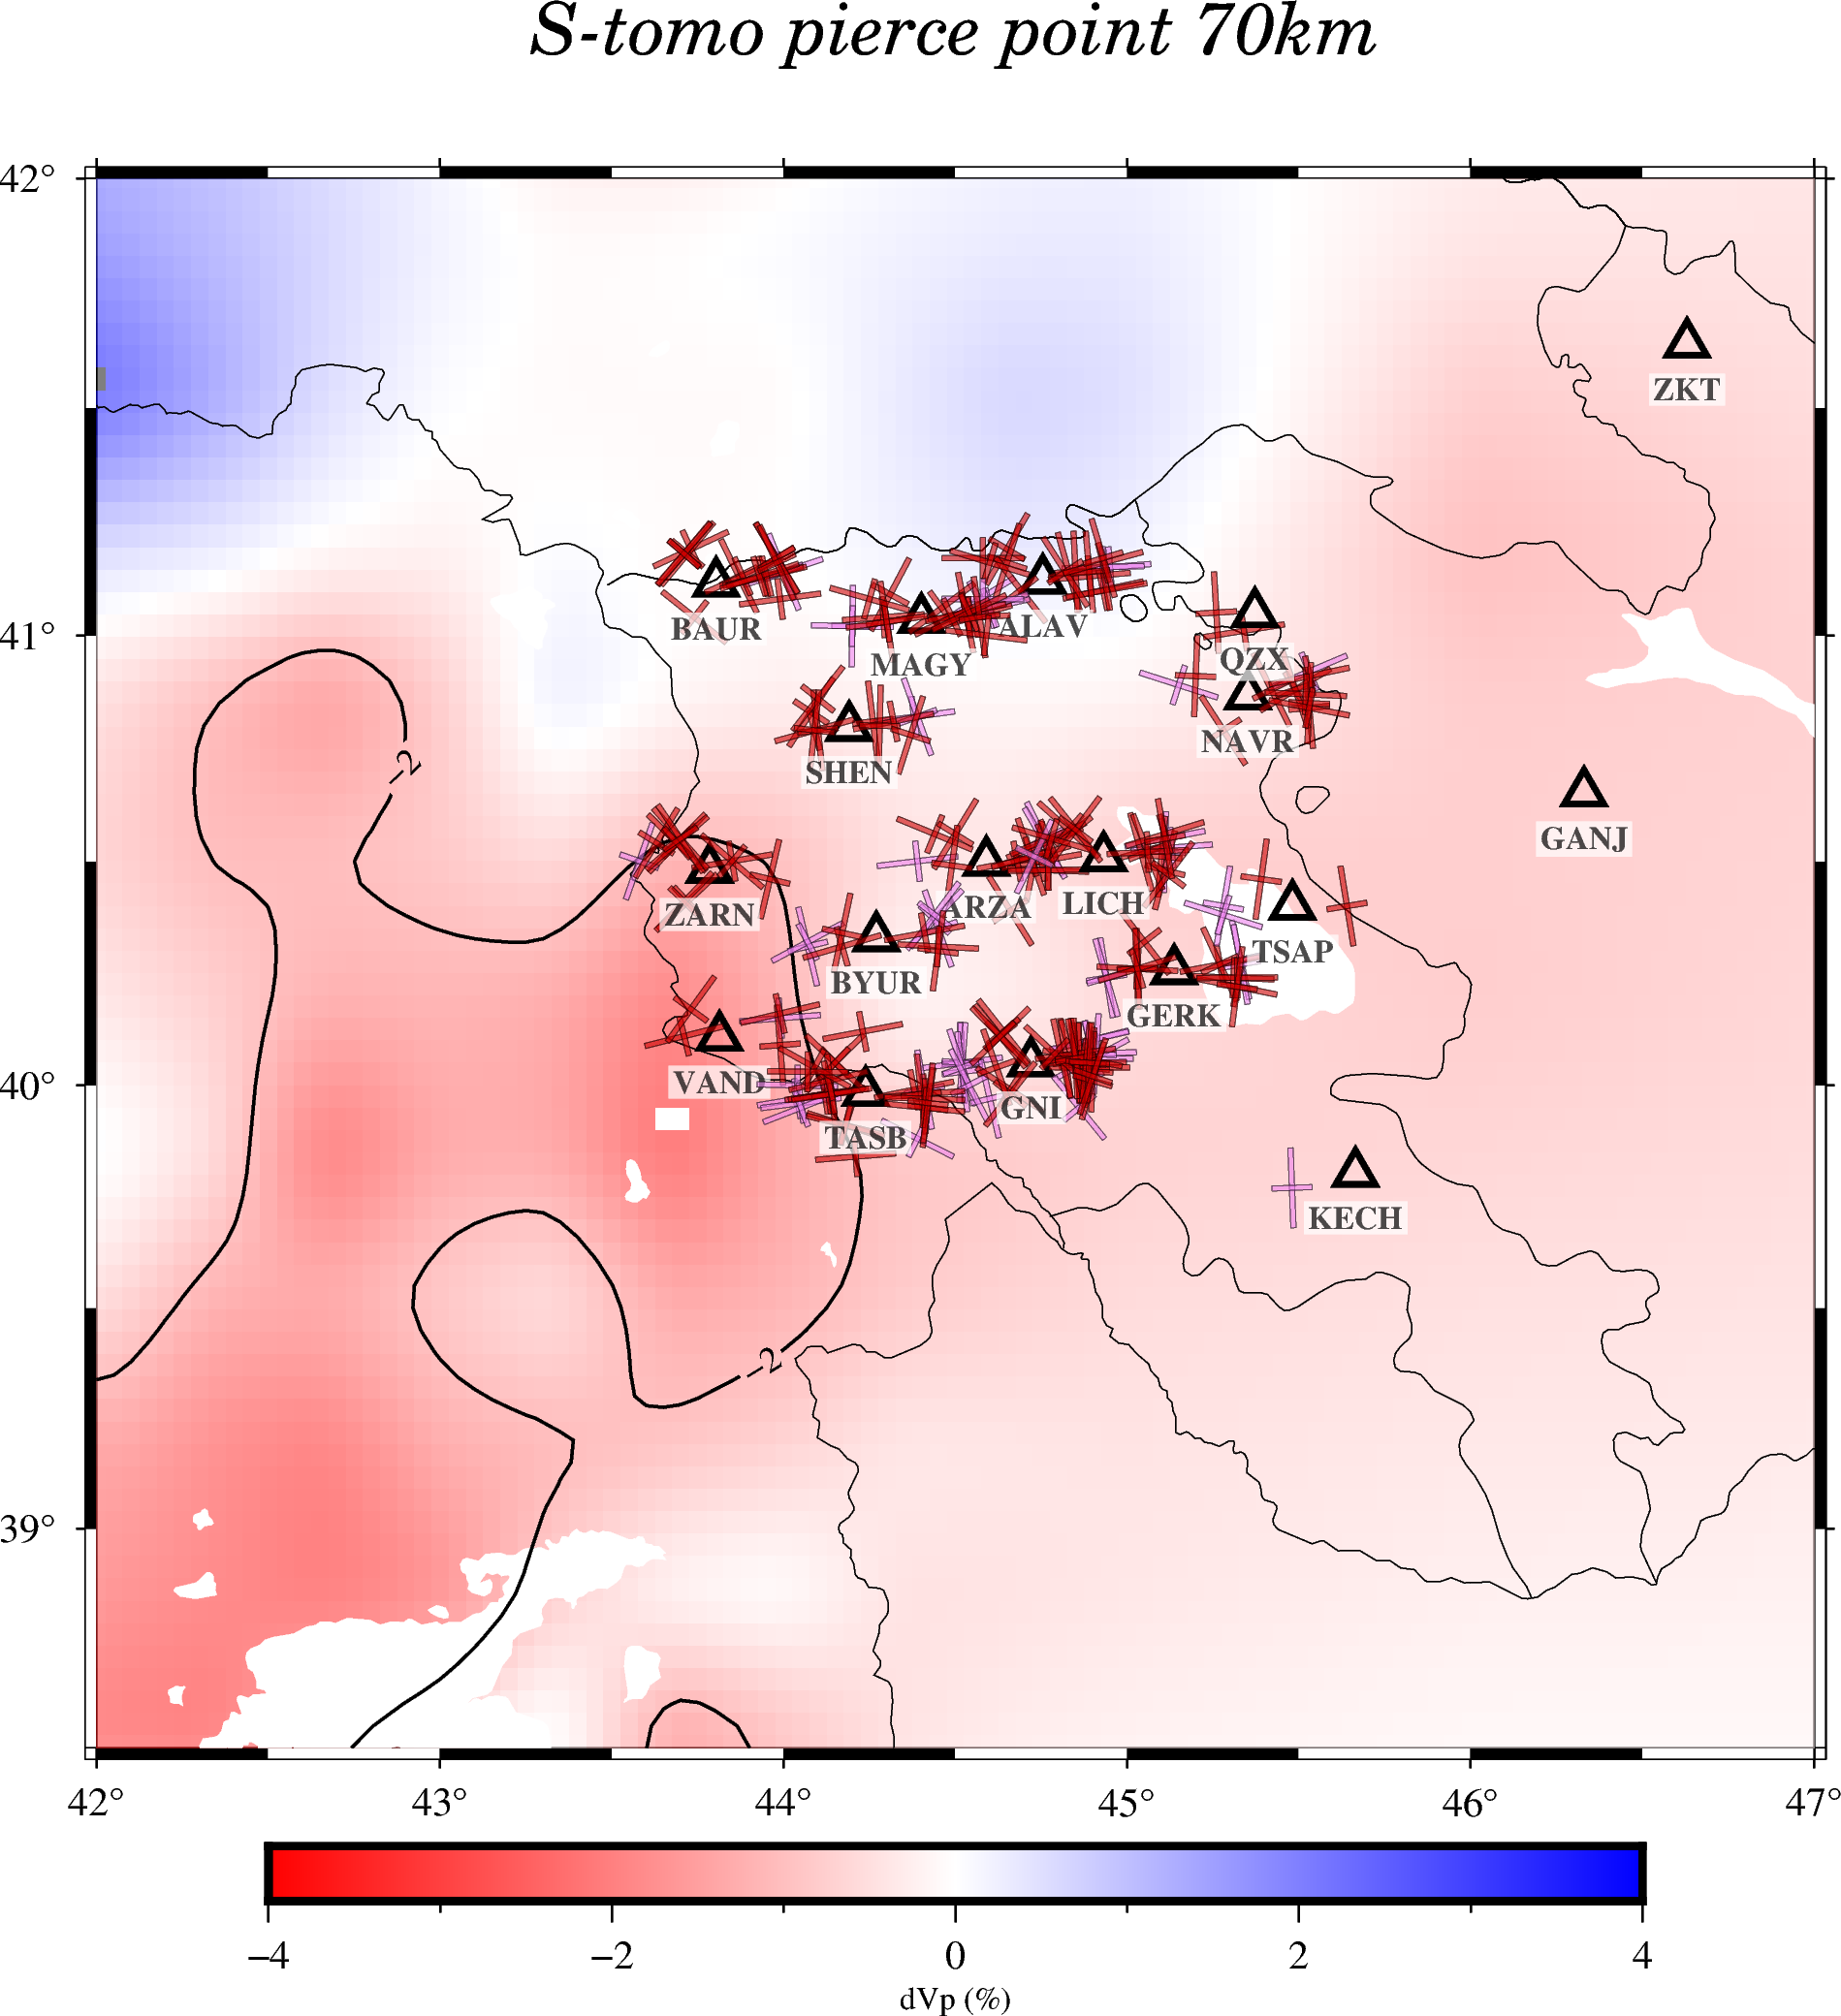

==================AM.ALAV==================
==================AM.ARZA==================
==================AM.BAUR==================
==================AM.BYUR==================
==================AM.GERK==================
==================AM.KECH==================
==================AM.LICH==================
==================AM.MAGY==================
==================AM.NAVR==================
==================AM.SHEN==================
==================AM.TSAP==================
==================AM.VAND==================
==================AM.ZARN==================
==================IU.GNI==================
==================KO.BCA==================
==================KO.TASB==================
==================AB.GANJ==================
==================AB.QZX==================
==================AB.ZKT==================


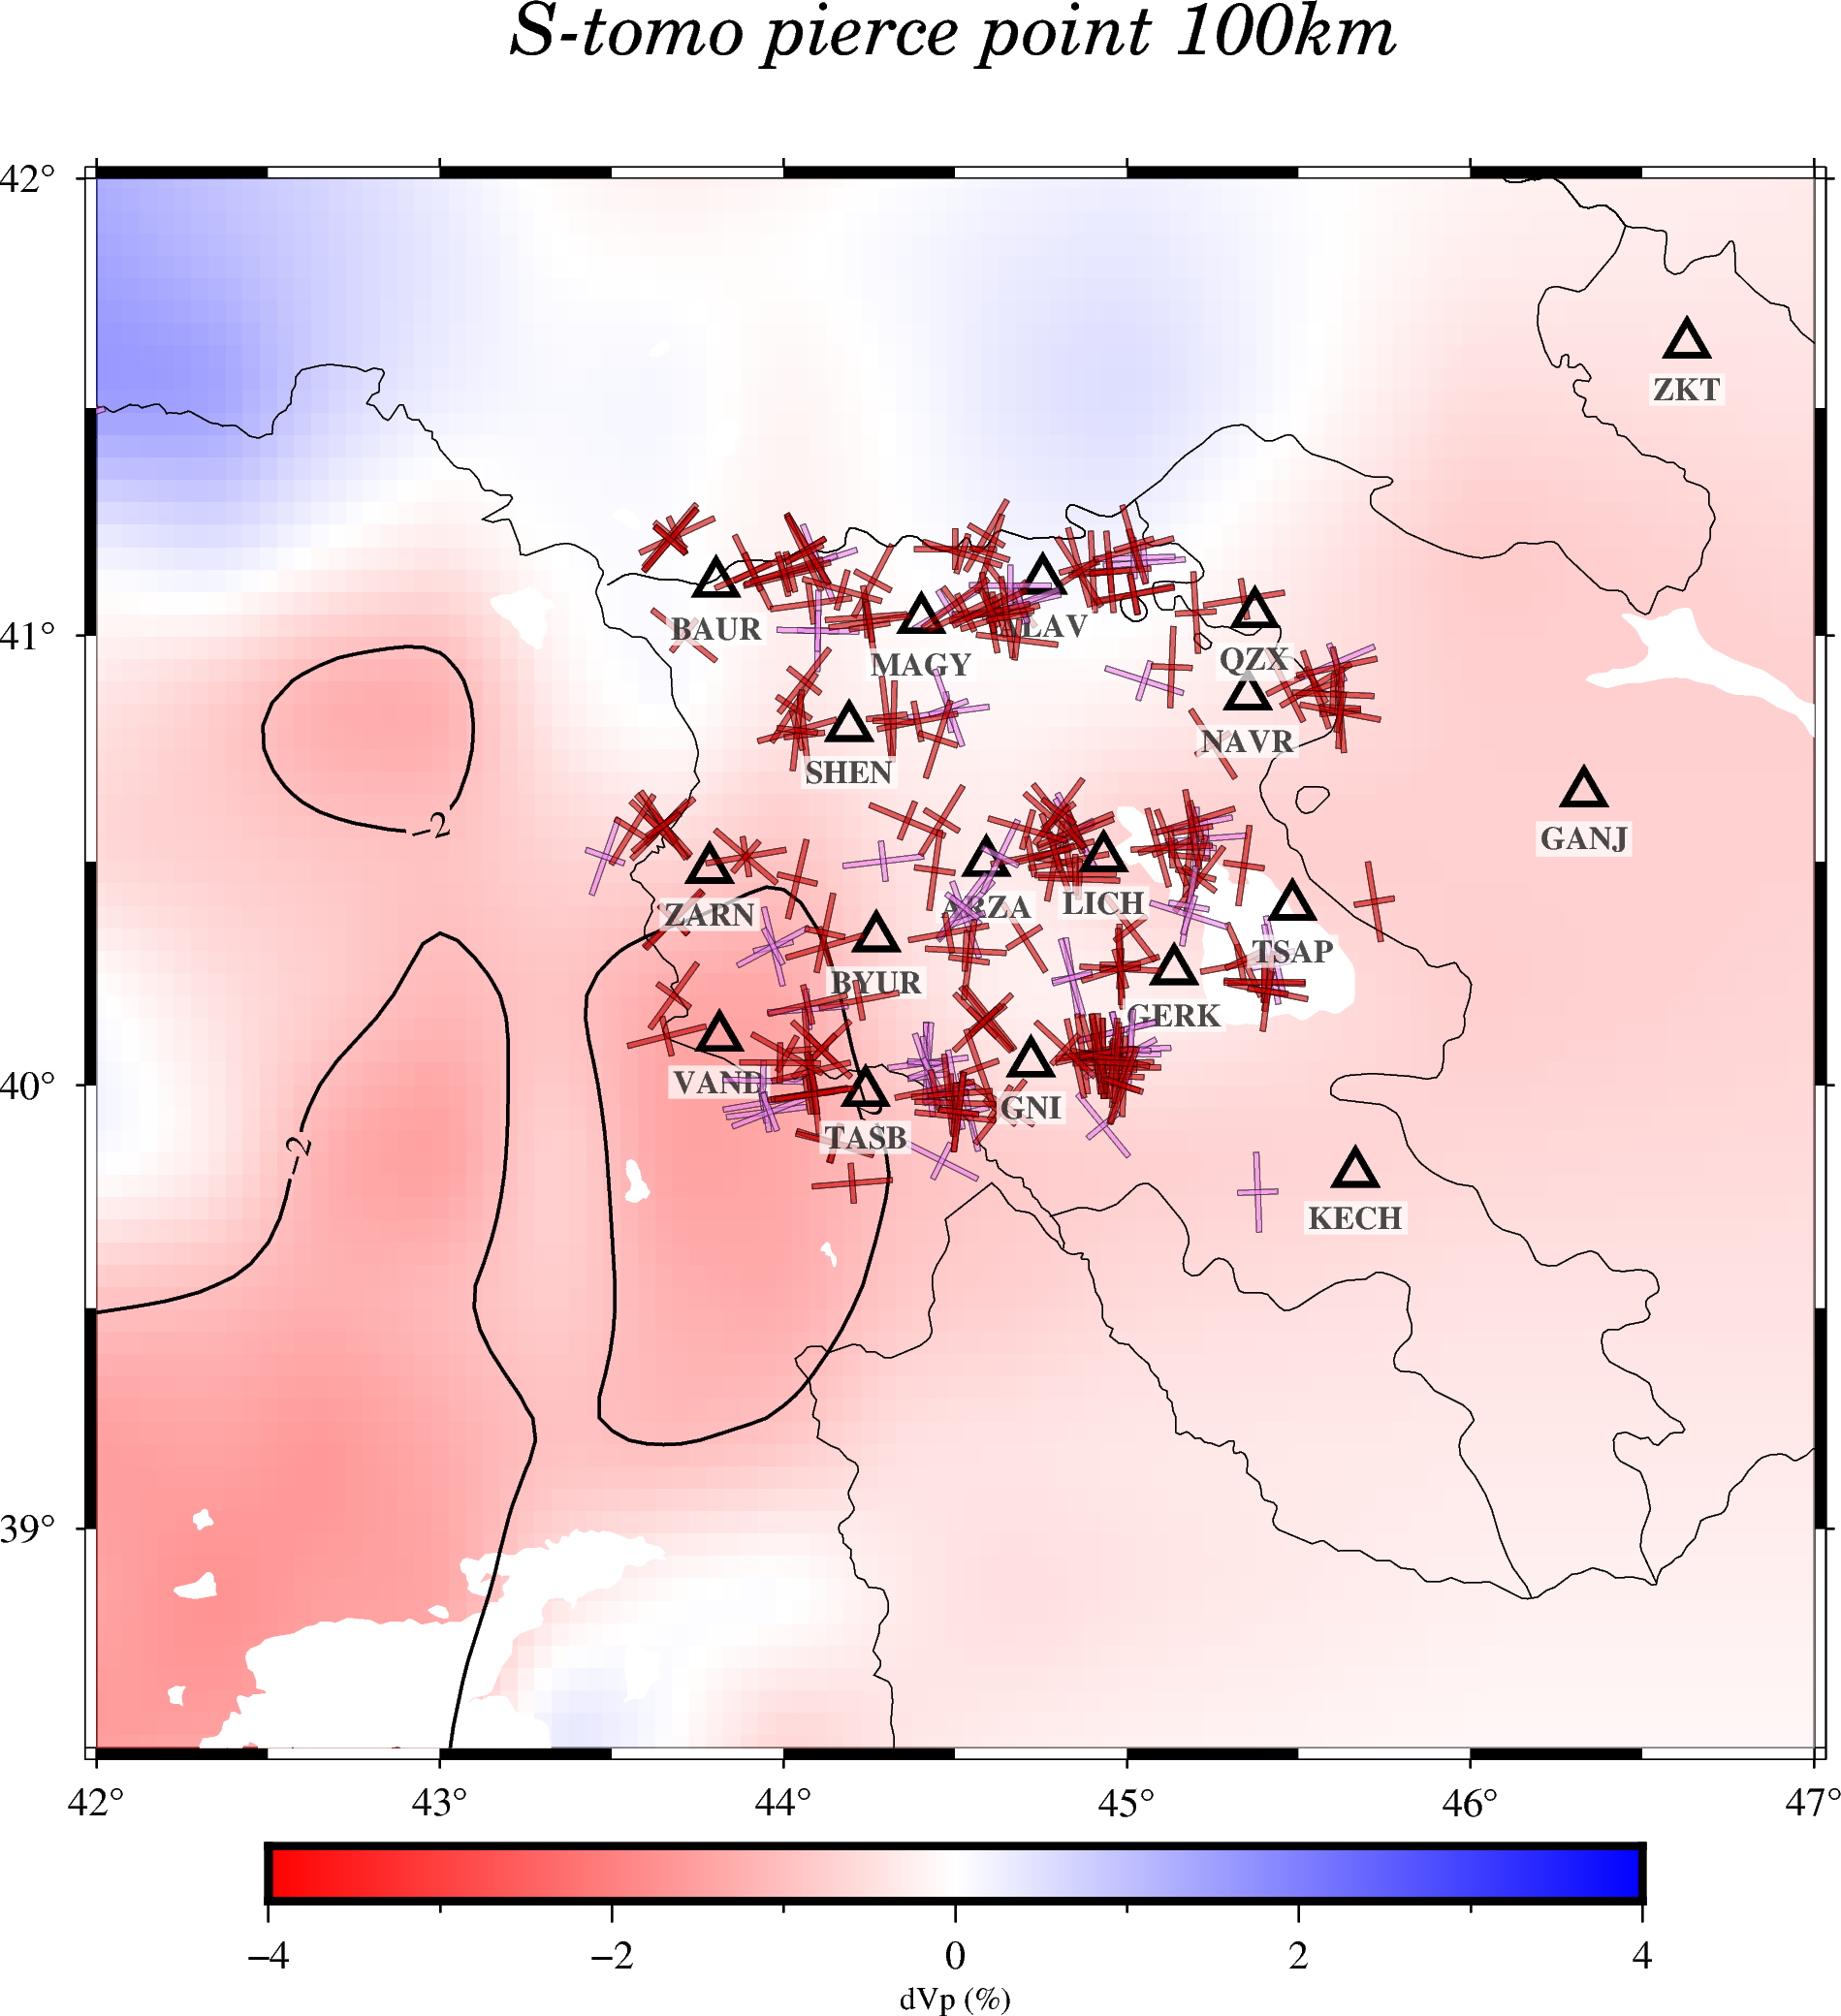

==================AM.ALAV==================
==================AM.ARZA==================
==================AM.BAUR==================
==================AM.BYUR==================
==================AM.GERK==================
==================AM.KECH==================
==================AM.LICH==================
==================AM.MAGY==================
==================AM.NAVR==================
==================AM.SHEN==================
==================AM.TSAP==================
==================AM.VAND==================
==================AM.ZARN==================
==================IU.GNI==================
==================KO.BCA==================
==================KO.TASB==================
==================AB.GANJ==================
==================AB.QZX==================
==================AB.ZKT==================


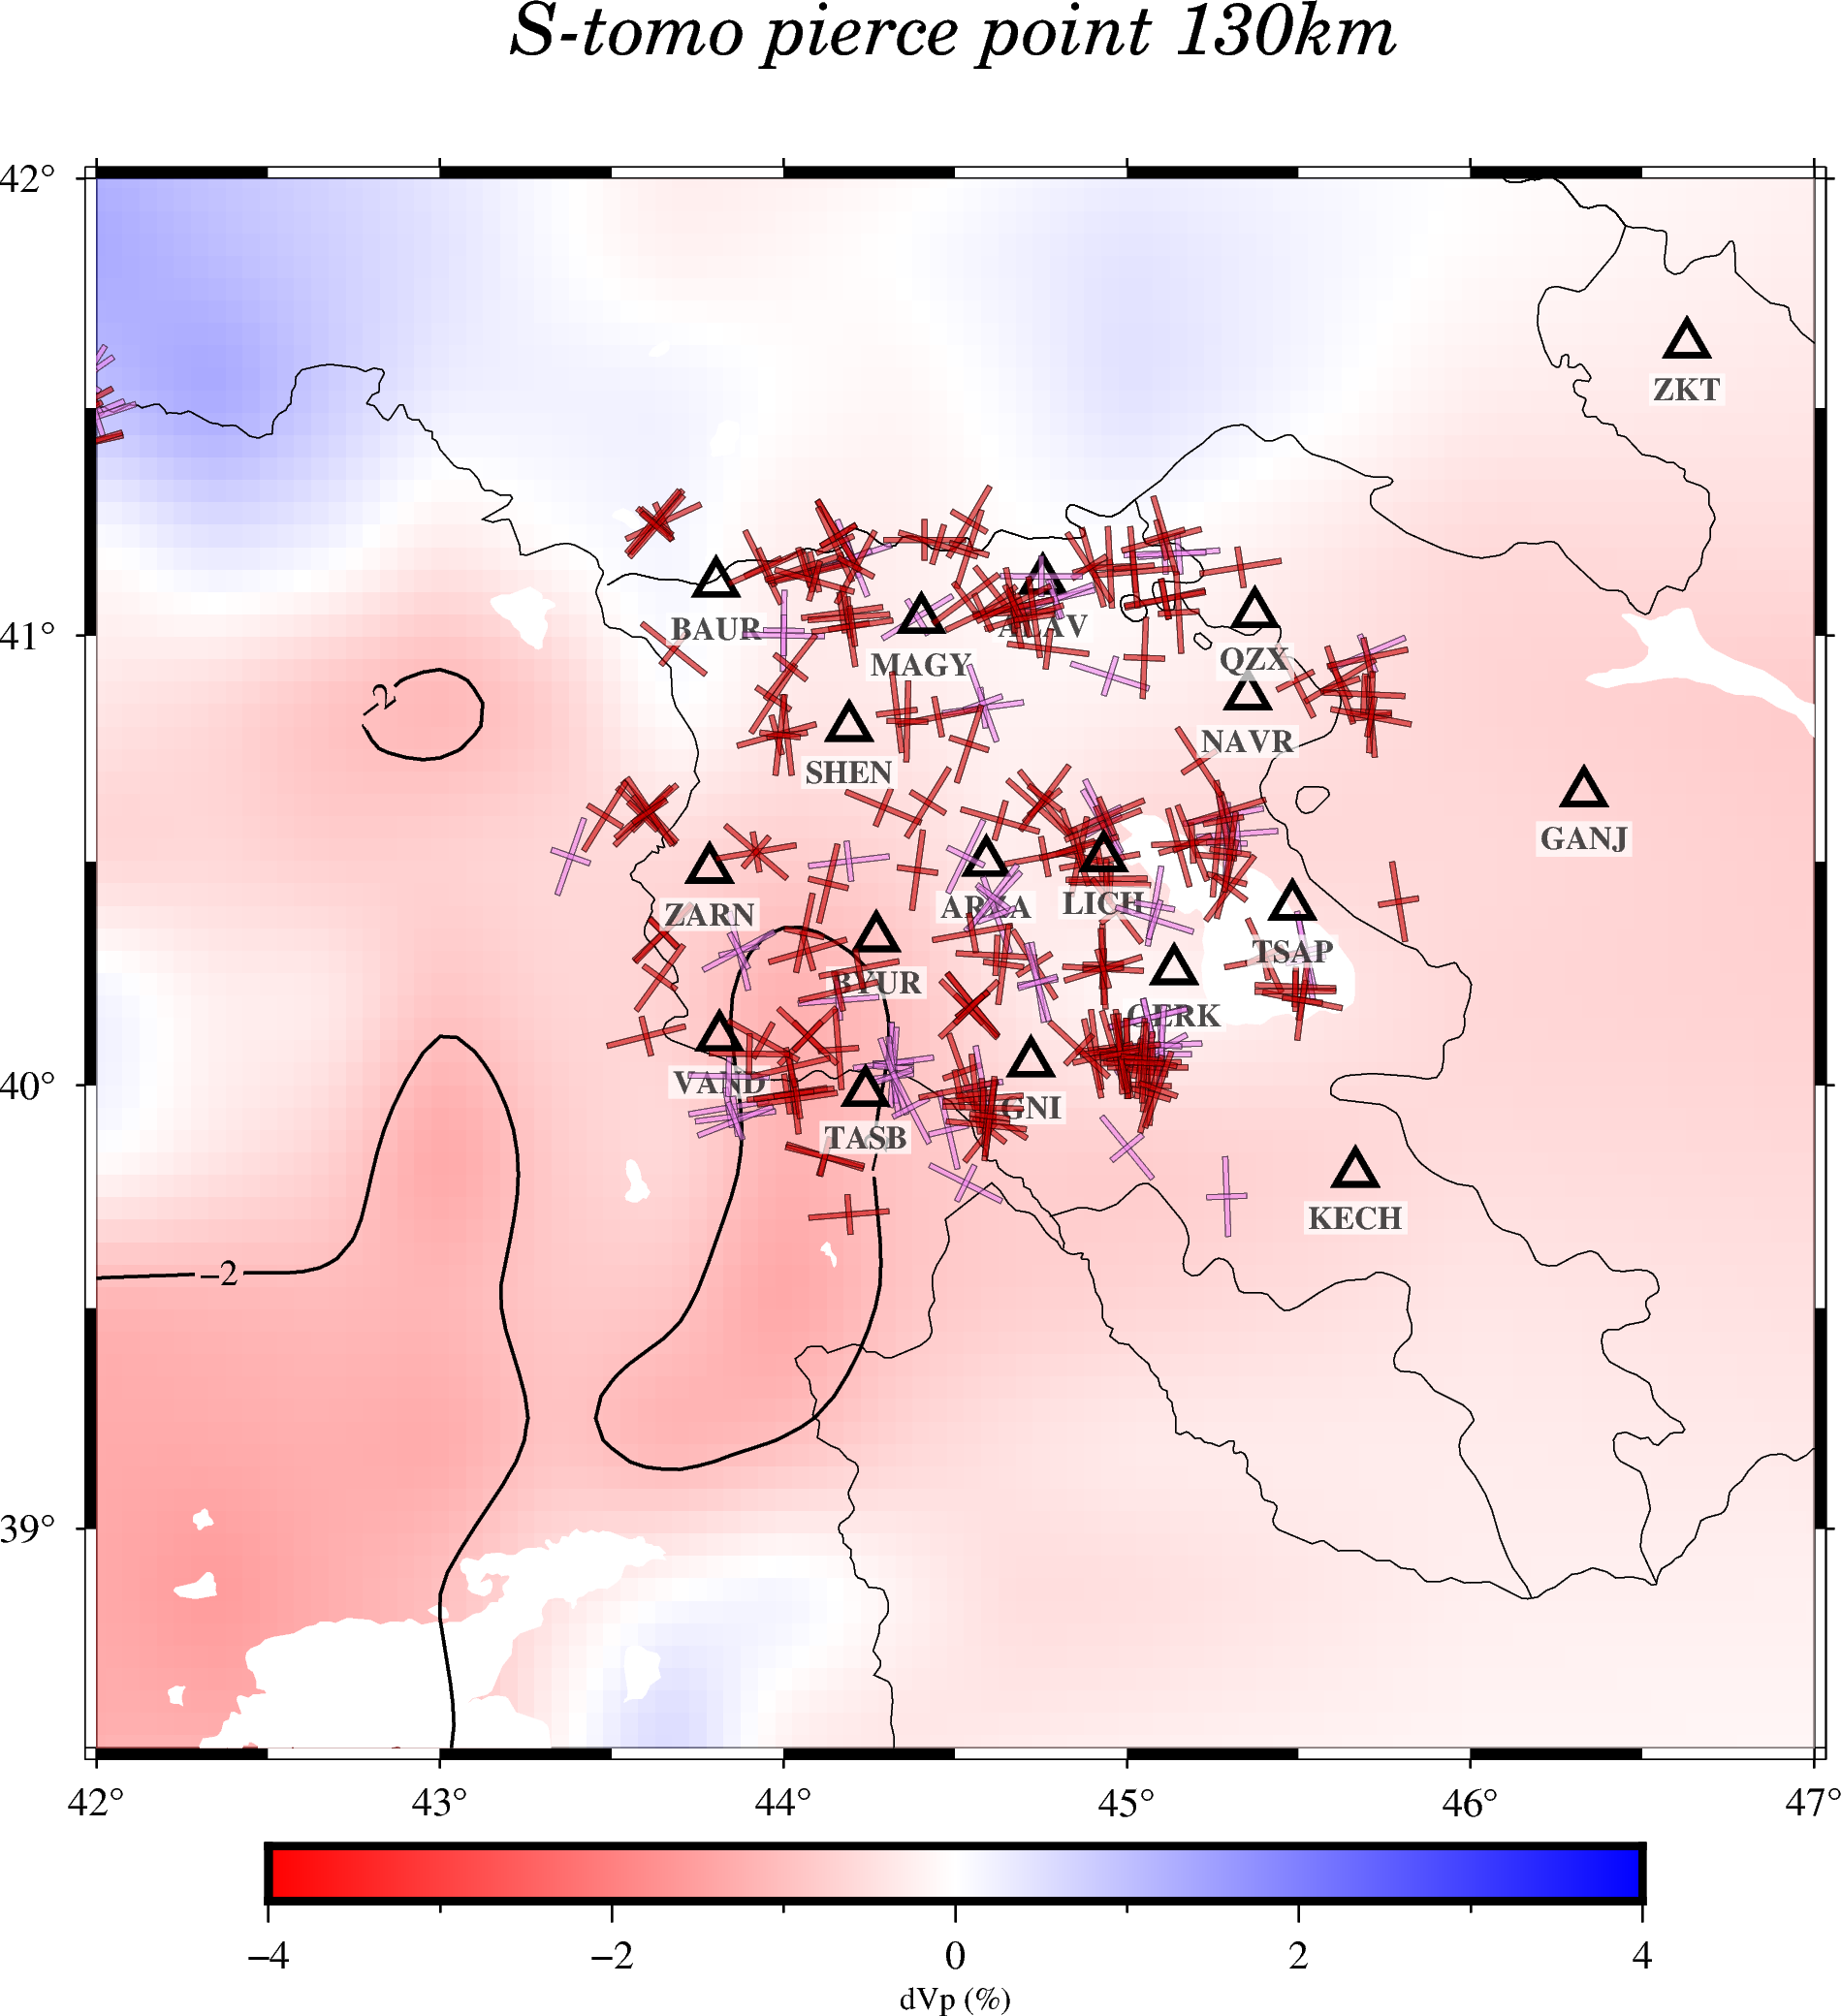

==================AM.ALAV==================
==================AM.ARZA==================
==================AM.BAUR==================
==================AM.BYUR==================
==================AM.GERK==================
==================AM.KECH==================
==================AM.LICH==================
==================AM.MAGY==================
==================AM.NAVR==================
==================AM.SHEN==================
==================AM.TSAP==================
==================AM.VAND==================
==================AM.ZARN==================
==================IU.GNI==================
==================KO.BCA==================
==================KO.TASB==================
==================AB.GANJ==================
==================AB.QZX==================
==================AB.ZKT==================


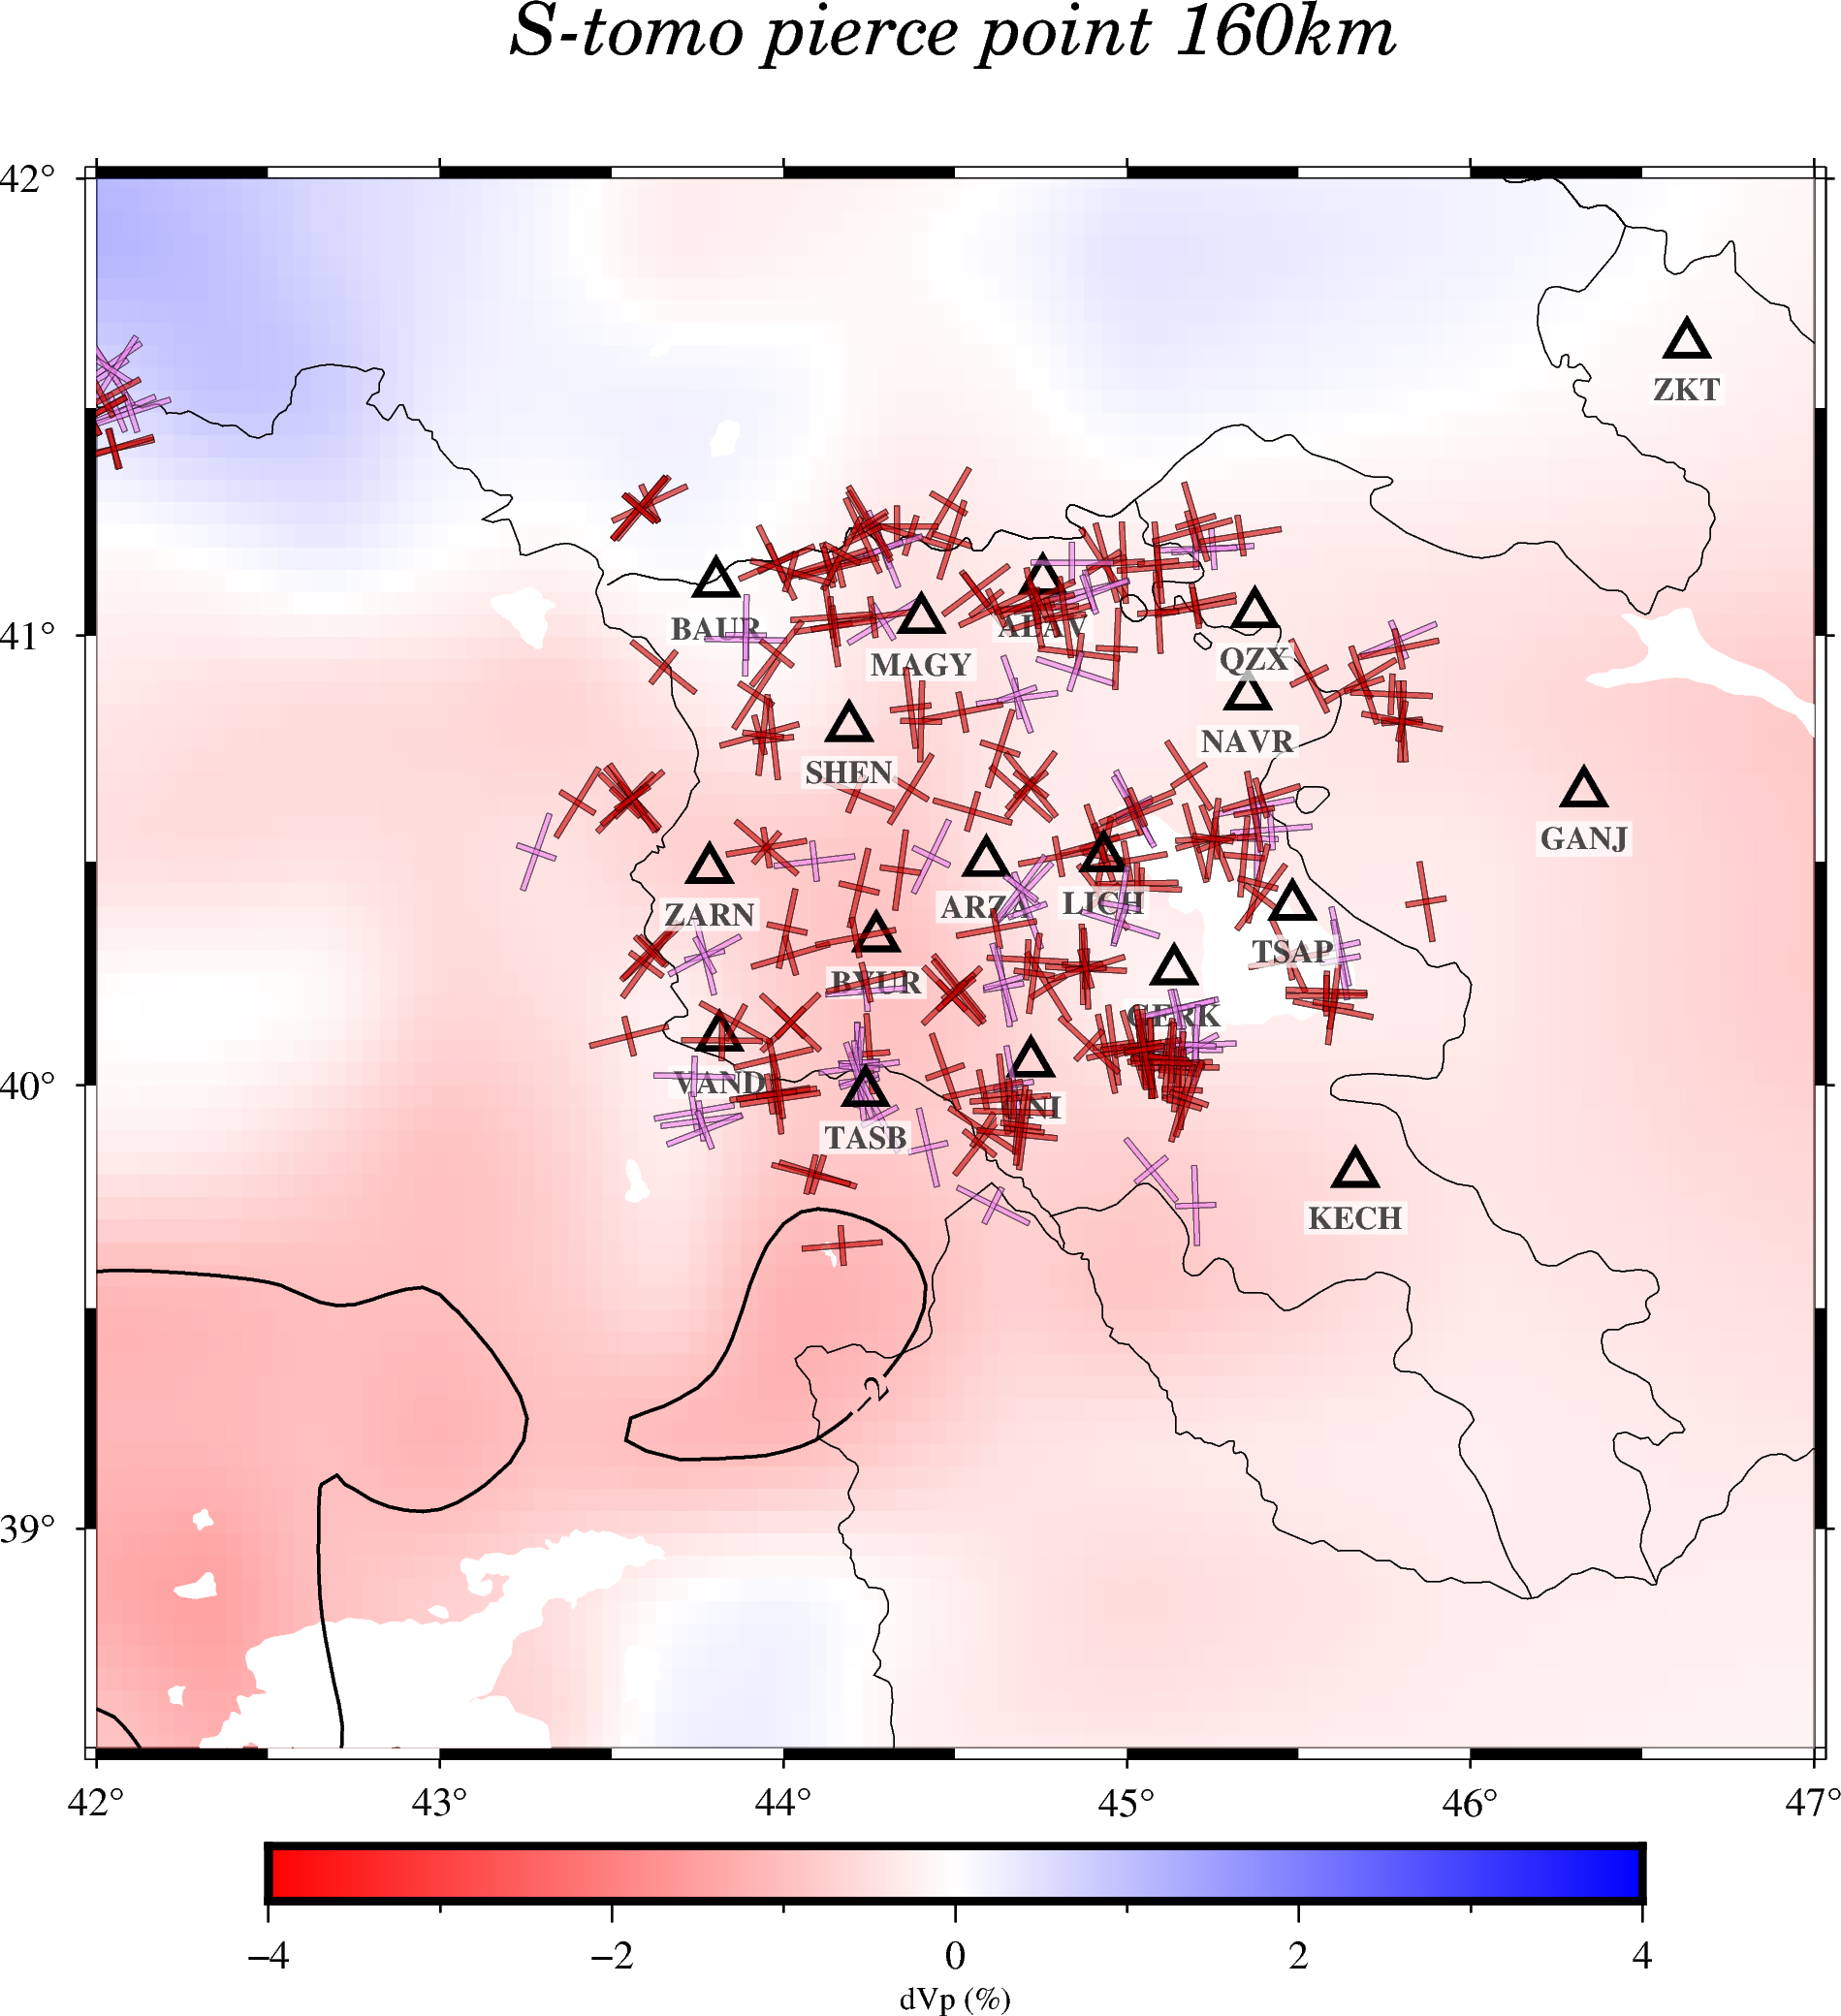

==================AM.ALAV==================
==================AM.ARZA==================
==================AM.BAUR==================
==================AM.BYUR==================
==================AM.GERK==================
==================AM.KECH==================
==================AM.LICH==================
==================AM.MAGY==================
==================AM.NAVR==================
==================AM.SHEN==================
==================AM.TSAP==================
==================AM.VAND==================
==================AM.ZARN==================
==================IU.GNI==================
==================KO.BCA==================
==================KO.TASB==================
==================AB.GANJ==================
==================AB.QZX==================
==================AB.ZKT==================


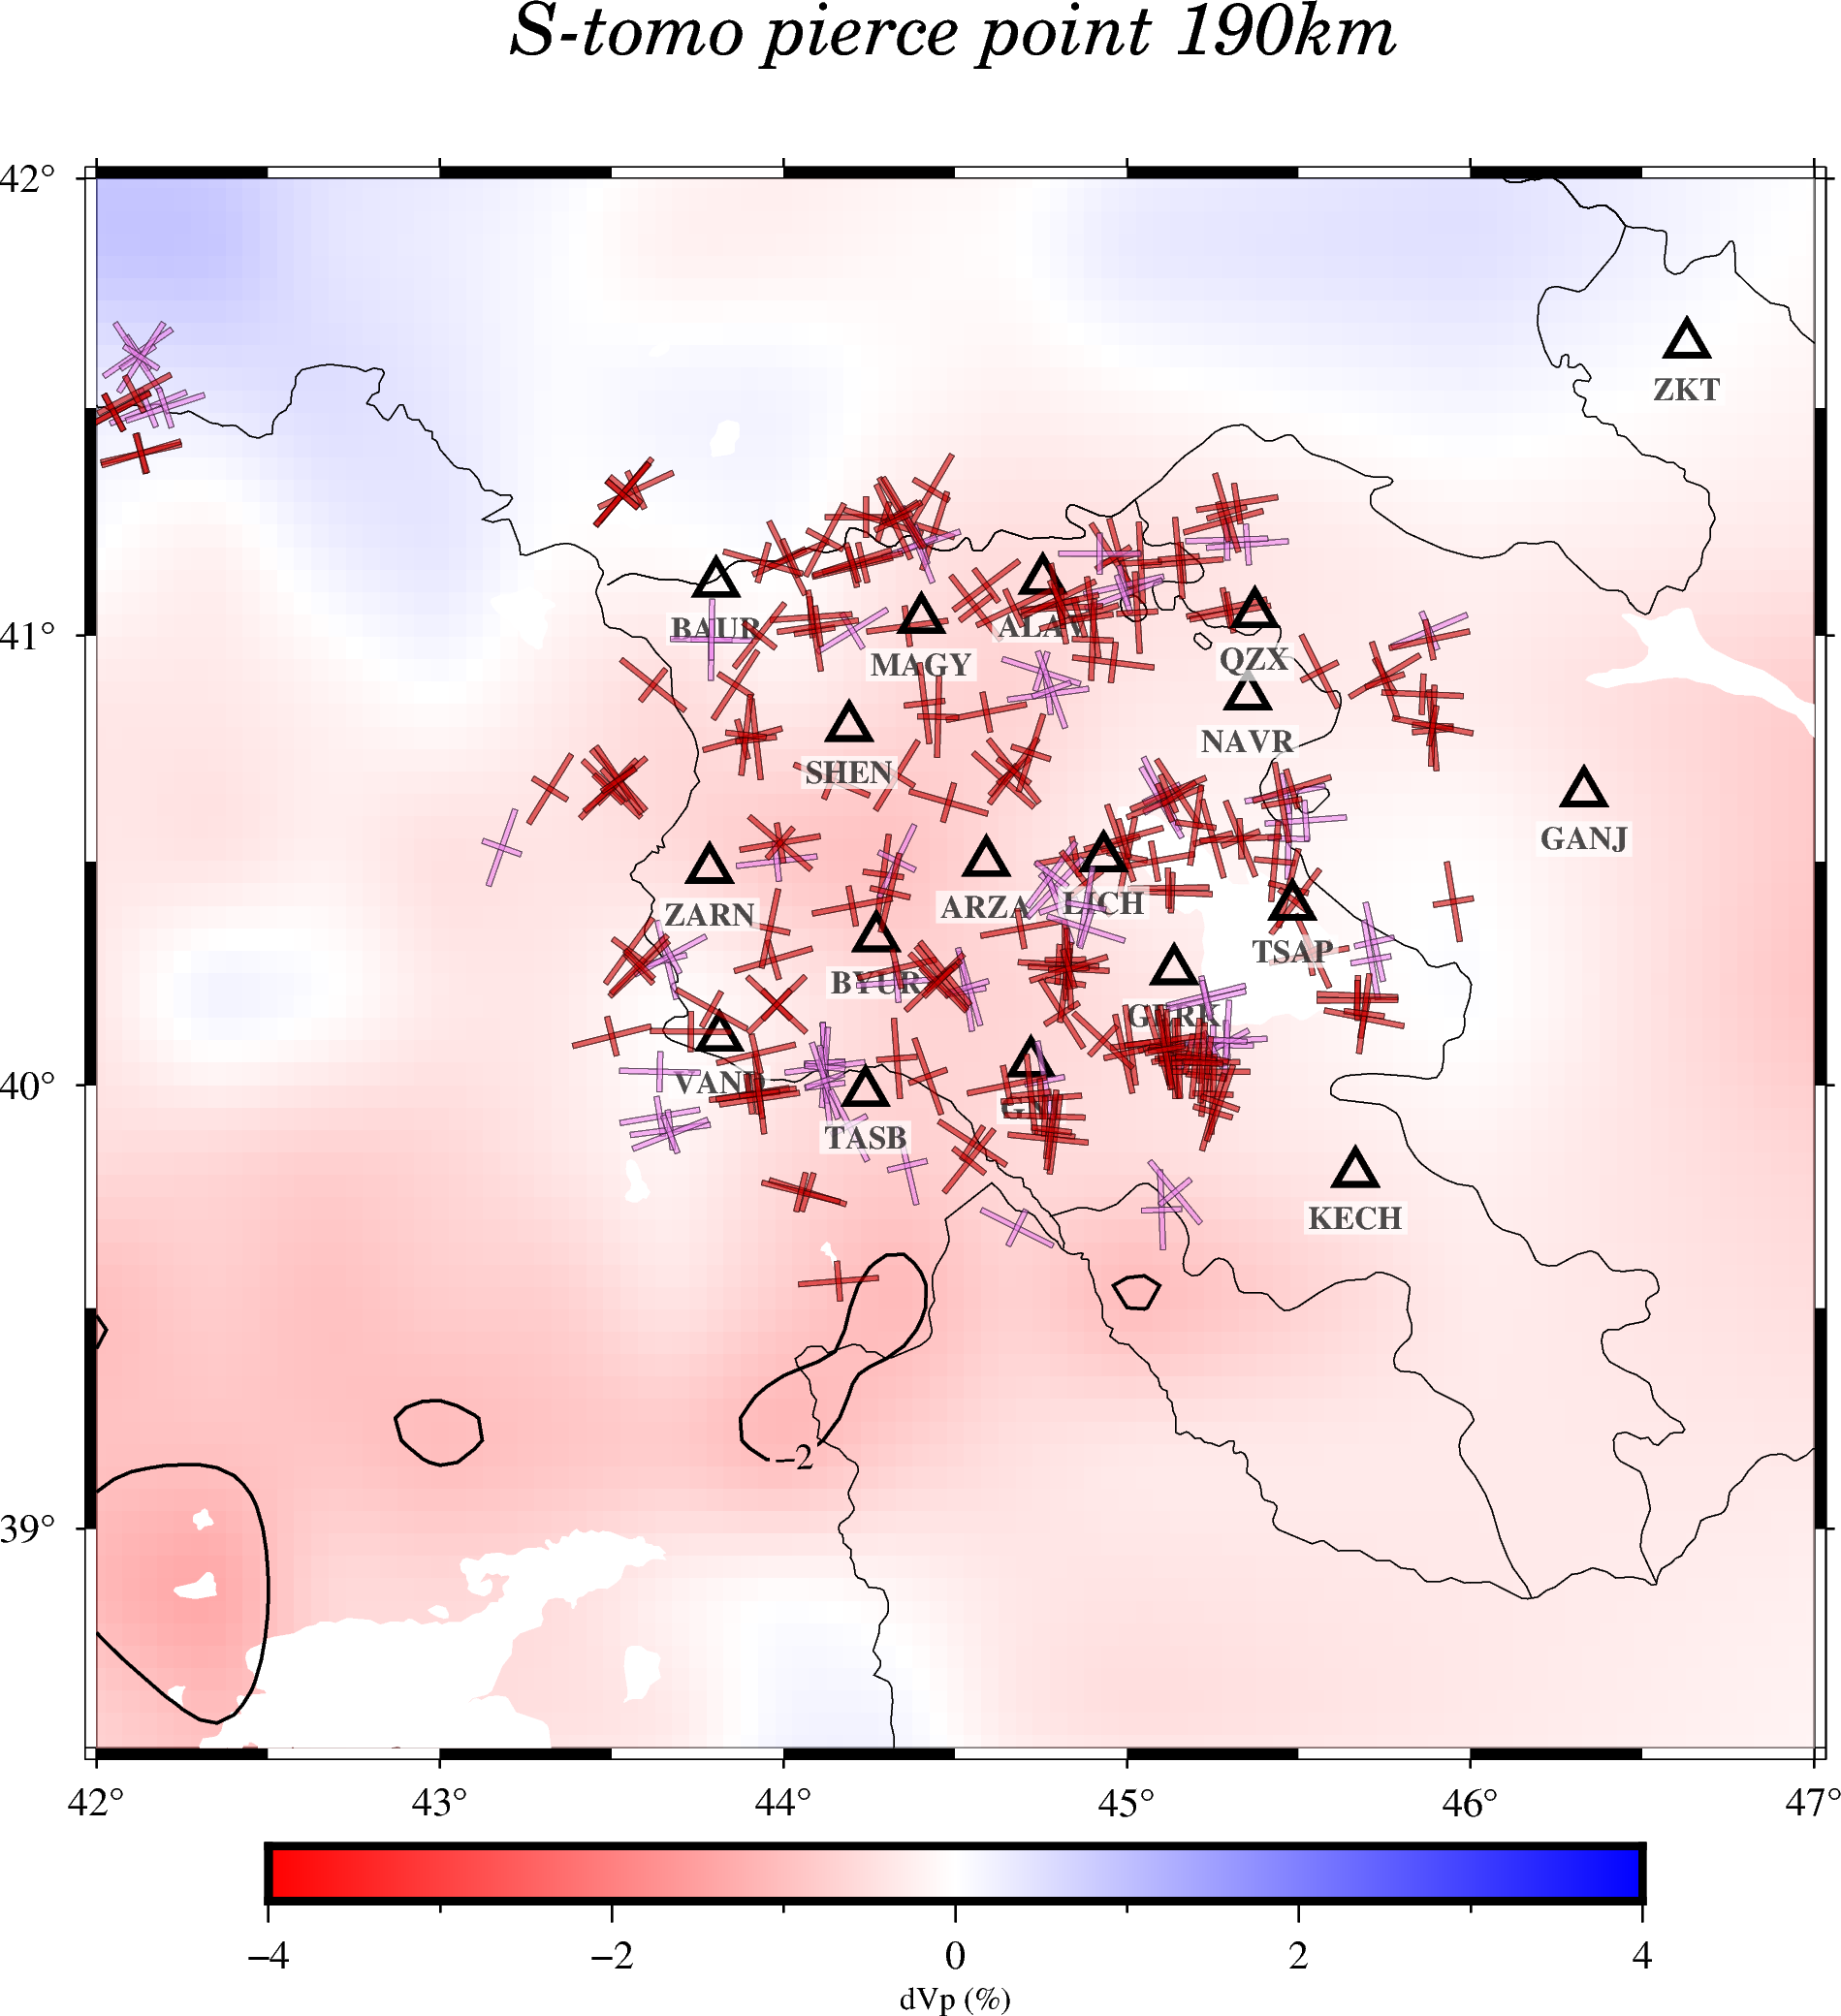

In [20]:
# region = [40, 47, 39.5, 44.5] original
region = [42, 47, 38.5, 42] ## for AM
# region = [40.5, 47, 40.5, 43.5] ## for GO
# region = [41, 44, 43, 44.5] ## for KIV
tomo='S'
fig = 'AM'

for PierceDep in range(70,200,30):
    figmap = pygmt.Figure()
    if tomo=='P':
        title = f"P-tomo pierce point {PierceDep}km"
    elif tomo=='S':
        title = f"S-tomo pierce point {PierceDep}km"
    PygmtBegin_tomo(figmap, region, title, PierceDep)
    for NET in ['AM','IU','KO','AB']:
        for pkl in sorted(glob.glob(f'{PKLpath}/{NET}*.pkl')):
            STApkl = pickle.load(open(pkl, "rb"))
            values = [value for keys, value in STApkl.items() ][0]
            net = values['network']; sta = values['station']
            stlat = values['latitude']; stlon = values['longitude']
           

            figmap.plot(x=stlon, y=stlat, style="t0.4c", pen="1.5p,black")
            print(f'=================={net}.{sta}==================')

            for resultpath in sorted(glob.glob(f'{path}/2010-2020_*_classify/{net}.{sta}*csv')):
                df = pd.read_csv(resultpath)
                dff = df[df['Null']==True][df['Quality']=='Good'][df['Pick']==True]
                for i in range(len(dff)):
                    event = dff['Event'].values[i]
                    evlat = dff['Ev_lat'].values[i]
                    evlon = dff['Ev_lon'].values[i]
                    evdep = dff['Depth'].values[i]
                    phase = dff['Phase'].values[i]

                    if method == 'SC': 
                        phi = dff['SCPhi'].values[i]
                        dt  = 0.5  ## due to null, the value isn't meaningful
                        if phase == 'SKS': color = 'red3'
                        elif phase == 'SKKS': color = 'violet'
                    elif method == 'RC': 
                        phi = dff['RCPhi'].values[i]
                        dt  = dff['RCdt'].values[i]          
                        if phase == 'SKS': color = 'deepskyblue1'
                        elif phase == 'SKKS': color = 'skyblue'            


                    p_lon, p_lat = PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep)
                    data = [[p_lon, p_lat, phi-90, 1.3, dt*40],[p_lon, p_lat, phi, 1.3, dt*20]]
                    figmap.plot(data=data, style="J", color=color, pen="0.1p,black",transparency=40)
                

            figmap.text(x=stlon,y=stlat-0.1,text=sta, font="8p,Times-Bold,black",fill='white',transparency=30)
#             print('-------end')
#             figmap.show()
#             if not os.path.exists(f'{figpath}/null/{net}.{sta}'):
#                 os.makedirs(f'{figpath}/null/{net}.{sta}')
#             figmap.savefig(f'{figpath}/null/{net}.{sta}/{net}.{sta}_{PierceDep}km_P.pdf')
#             figmap.savefig(f'{figpath}/null/{net}.{sta}/{net}.{sta}_{PierceDep}km_P.png', dpi=200)

            
    figmap.show()
        

In [9]:
for resultpath in sorted(glob.glob(f'{path}/2010-2020_*_classify/*AKH*result.csv')):
    print(resultpath)
    df = pd.read_csv(resultpath)

    print(len(df))
    dfff = df[df['Null']==False][df['Quality']!='Poor'][df['Pick']==True]
    print(len(dfff))

/Volumes/home/Research/STEP/02_Station_result_csv/2010-2020_SKKS_classify/GO.AKH_split_result.csv
44
13
/Volumes/home/Research/STEP/02_Station_result_csv/2010-2020_SKS_classify/GO.AKH_split_result.csv
92
17
